In [1]:
import numpy as np
import pandas as pd
import random
import os
import time
import pickle
from pathlib import Path

from os.path import join, isfile
from os import path, scandir, listdir

from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
#import xgboost as xgb
#import catboost as ctb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# Parameters

In [2]:
target = 'target'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 2017
    CVSEED = 2017
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 5
    N_ESTIMATORS = 20000
    EARLY_STOPPING_ROUNDS = 300
    VERBOSE = 1000
    SEED = 2017
    CVSEED = 2017
    #N_ITERS = 10

In [3]:
def set_seed(seed=2017):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Datasets

In [4]:
INPUT = Path("../input/tabular-playground-series-oct-2021")

train = pd.DataFrame(pd.read_csv(INPUT / "train.csv")[target])
#test = pd.read_csv(INPUT / "test.csv")
test = pd.DataFrame()
submission = pd.read_csv(INPUT / "sample_submission.csv")

In [5]:
def list_all_files(location='../input/tps-oct-lv0', pattern=None, recursive=True):
    """
    This function returns a list of files at a given location (including subfolders)
    
    - location: path to the directory to be searched
    - pattern: part of the file name to be searched (ex. pattern='.csv' would return all the csv files)
    - recursive: boolean, if True the function calls itself for every subdirectory it finds
    """
    subdirectories= [f.path for f in scandir(location) if f.is_dir()]
    files = [join(location, f) for f in listdir(location) if isfile(join(location, f))]
    if recursive:
        for directory in subdirectories:
            files.extend(list_all_files(directory))
    if pattern:
        files = [f for f in files if pattern in f]
    return files

In [6]:
names = ['bizen', 'henke', 'hamza', '28smiles','kashif', 'kosta', 'kaveh', 'dlaststark', 'pca', 'xgb2']

In [7]:
namesec = ['lonnie', 'hgb', 'xgb_d2s', 'ctb_d2s']

In [8]:
pred = list_all_files(pattern='oof')


for i in range(len(names)):
    cnt=1
    for file in pred:
        if names[i] in file.split('/')[3]:
            train[names[i]+str(cnt)] = np.load(file) 
            cnt += 1
            
pred = list_all_files(location='../input/tps-oct-lv0-sec', pattern='oof')

for i in range(len(namesec)):
    cnt=1
    for file in pred:
        if namesec[i] in file.split('/')[3]:
            train[namesec[i]+str(cnt)] = np.load(file) 
            cnt += 1
            
train.columns

Index(['target', 'bizen1', 'bizen2', 'bizen3', 'bizen4', 'bizen5', 'henke1',
       'henke2', 'henke3', 'henke4', 'henke5', 'hamza1', 'hamza2', 'hamza3',
       'hamza4', 'hamza5', '28smiles1', '28smiles2', '28smiles3', '28smiles4',
       '28smiles5', 'kashif1', 'kashif2', 'kashif3', 'kashif4', 'kashif5',
       'kosta1', 'kosta2', 'kosta3', 'kosta4', 'kosta5', 'kaveh1', 'kaveh2',
       'kaveh3', 'kaveh4', 'kaveh5', 'dlaststark1', 'dlaststark2',
       'dlaststark3', 'dlaststark4', 'dlaststark5', 'pca1', 'pca2', 'pca3',
       'pca4', 'pca5', 'xgb21', 'xgb22', 'xgb23', 'xgb24', 'xgb25', 'lonnie1',
       'lonnie2', 'lonnie3', 'lonnie4', 'lonnie5', 'hgb1', 'hgb2', 'hgb3',
       'hgb4', 'hgb5', 'xgb_d2s1', 'xgb_d2s2', 'xgb_d2s3', 'xgb_d2s4',
       'xgb_d2s5', 'ctb_d2s1', 'ctb_d2s2', 'ctb_d2s3', 'ctb_d2s4', 'ctb_d2s5'],
      dtype='object')

In [9]:
pred = list_all_files(pattern='pred')


for i in range(len(names)):
    cnt=1
    for file in pred:
        if names[i] in file.split('/')[3]:
            test[names[i]+str(cnt)] = np.load(file) 
            cnt += 1
            
pred = list_all_files(location='../input/tps-oct-lv0-sec', pattern='pred')

for i in range(len(namesec)):
    cnt=1
    for file in pred:
        if namesec[i] in file.split('/')[3]:
            test[namesec[i]+str(cnt)] = np.load(file) 
            cnt += 1
    
test.columns

Index(['bizen1', 'bizen2', 'bizen3', 'bizen4', 'bizen5', 'henke1', 'henke2',
       'henke3', 'henke4', 'henke5', 'hamza1', 'hamza2', 'hamza3', 'hamza4',
       'hamza5', '28smiles1', '28smiles2', '28smiles3', '28smiles4',
       '28smiles5', 'kashif1', 'kashif2', 'kashif3', 'kashif4', 'kashif5',
       'kosta1', 'kosta2', 'kosta3', 'kosta4', 'kosta5', 'kaveh1', 'kaveh2',
       'kaveh3', 'kaveh4', 'kaveh5', 'dlaststark1', 'dlaststark2',
       'dlaststark3', 'dlaststark4', 'dlaststark5', 'pca1', 'pca2', 'pca3',
       'pca4', 'pca5', 'xgb21', 'xgb22', 'xgb23', 'xgb24', 'xgb25', 'lonnie1',
       'lonnie2', 'lonnie3', 'lonnie4', 'lonnie5', 'hgb1', 'hgb2', 'hgb3',
       'hgb4', 'hgb5', 'xgb_d2s1', 'xgb_d2s2', 'xgb_d2s3', 'xgb_d2s4',
       'xgb_d2s5', 'ctb_d2s1', 'ctb_d2s2', 'ctb_d2s3', 'ctb_d2s4', 'ctb_d2s5'],
      dtype='object')

In [10]:
for i in range(5):

    train['lgb'+str(i+1)] = np.load("../input/tps-oct-lv0/"+str(i+2017)+"lgb_oof.npy")
    test['lgb'+str(i+1)] = np.load("../input/tps-oct-lv0/"+str(i+2017)+"lgb_pred.npy")
    
    train['xgb'+str(i+1)] = np.load("../input/tps-oct-lv0/agg"+str(i+1)+"_xgb_oof.npy")
    test['xgb'+str(i+1)] = np.load("../input/tps-oct-lv0/agg"+str(i+1)+"_xgb_pred.npy")

In [11]:
#lv1

nameslv1 = ['ridge', 'gnb', 'lgb', 'xgb', 'rf', 'nn']

pred = list_all_files(location='../input/tps-oct-lv1-backup', pattern='oof')


for i in range(len(nameslv1)):
    cnt=1
    for file in pred:
        if nameslv1[i] in file.split('/')[3]:
            train[nameslv1[i]+str(cnt)] = np.load(file) 
            cnt += 1
    
train.columns

Index(['target', 'bizen1', 'bizen2', 'bizen3', 'bizen4', 'bizen5', 'henke1',
       'henke2', 'henke3', 'henke4', 'henke5', 'hamza1', 'hamza2', 'hamza3',
       'hamza4', 'hamza5', '28smiles1', '28smiles2', '28smiles3', '28smiles4',
       '28smiles5', 'kashif1', 'kashif2', 'kashif3', 'kashif4', 'kashif5',
       'kosta1', 'kosta2', 'kosta3', 'kosta4', 'kosta5', 'kaveh1', 'kaveh2',
       'kaveh3', 'kaveh4', 'kaveh5', 'dlaststark1', 'dlaststark2',
       'dlaststark3', 'dlaststark4', 'dlaststark5', 'pca1', 'pca2', 'pca3',
       'pca4', 'pca5', 'xgb21', 'xgb22', 'xgb23', 'xgb24', 'xgb25', 'lonnie1',
       'lonnie2', 'lonnie3', 'lonnie4', 'lonnie5', 'hgb1', 'hgb2', 'hgb3',
       'hgb4', 'hgb5', 'xgb_d2s1', 'xgb_d2s2', 'xgb_d2s3', 'xgb_d2s4',
       'xgb_d2s5', 'ctb_d2s1', 'ctb_d2s2', 'ctb_d2s3', 'ctb_d2s4', 'ctb_d2s5',
       'lgb1', 'xgb1', 'lgb2', 'xgb2', 'lgb3', 'xgb3', 'lgb4', 'xgb4', 'lgb5',
       'xgb5', 'ridge1', 'gnb1', 'rf1', 'nn1'],
      dtype='object')

In [12]:
pred = list_all_files(location='../input/tps-oct-lv1-backup', pattern='pred')

for i in range(len(nameslv1)):
    cnt=1
    for file in pred:
        if nameslv1[i] in file.split('/')[3]:
            test[nameslv1[i]+str(cnt)] = np.load(file) 
            cnt += 1
    
test.columns

Index(['bizen1', 'bizen2', 'bizen3', 'bizen4', 'bizen5', 'henke1', 'henke2',
       'henke3', 'henke4', 'henke5', 'hamza1', 'hamza2', 'hamza3', 'hamza4',
       'hamza5', '28smiles1', '28smiles2', '28smiles3', '28smiles4',
       '28smiles5', 'kashif1', 'kashif2', 'kashif3', 'kashif4', 'kashif5',
       'kosta1', 'kosta2', 'kosta3', 'kosta4', 'kosta5', 'kaveh1', 'kaveh2',
       'kaveh3', 'kaveh4', 'kaveh5', 'dlaststark1', 'dlaststark2',
       'dlaststark3', 'dlaststark4', 'dlaststark5', 'pca1', 'pca2', 'pca3',
       'pca4', 'pca5', 'xgb21', 'xgb22', 'xgb23', 'xgb24', 'xgb25', 'lonnie1',
       'lonnie2', 'lonnie3', 'lonnie4', 'lonnie5', 'hgb1', 'hgb2', 'hgb3',
       'hgb4', 'hgb5', 'xgb_d2s1', 'xgb_d2s2', 'xgb_d2s3', 'xgb_d2s4',
       'xgb_d2s5', 'ctb_d2s1', 'ctb_d2s2', 'ctb_d2s3', 'ctb_d2s4', 'ctb_d2s5',
       'lgb1', 'xgb1', 'lgb2', 'xgb2', 'lgb3', 'xgb3', 'lgb4', 'xgb4', 'lgb5',
       'xgb5', 'ridge1', 'gnb1', 'rf1', 'nn1'],
      dtype='object')

In [13]:
train

,target,bizen1,bizen2,bizen3,bizen4,bizen5,henke1,henke2,henke3,henke4,...,lgb3,xgb3,lgb4,xgb4,lgb5,xgb5,ridge1,gnb1,rf1,nn1
0,1,0.685970,0.662352,0.683341,0.680801,0.662460,0.678655,0.656029,0.680616,0.649345,...,0.666535,0.685974,0.661209,0.675093,0.664779,0.669547,0.662315,9.999887e-01,0.627828,0.631537
1,1,0.164244,0.175831,0.182369,0.179480,0.184402,0.173803,0.186263,0.179768,0.198704,...,0.195837,0.168033,0.186122,0.176252,0.173731,0.173688,0.219062,2.156250e-09,0.234431,0.202800
2,1,0.844541,0.846079,0.858312,0.857051,0.853688,0.866199,0.867833,0.866303,0.864103,...,0.843738,0.857366,0.850835,0.839731,0.849409,0.834846,0.806280,1.000000e+00,0.789477,0.826836
3,1,0.531215,0.519297,0.512399,0.528917,0.522211,0.522347,0.517418,0.516195,0.519794,...,0.510195,0.517595,0.512810,0.530310,0.500083,0.510080,0.515744,5.438057e-01,0.504650,0.504434
4,1,0.831099,0.825800,0.823048,0.842095,0.831419,0.822539,0.819840,0.831176,0.824627,...,0.838210,0.833570,0.835198,0.837250,0.830752,0.825002,0.788321,1.000000e+00,0.769031,0.802022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1,0.749454,0.728286,0.750493,0.756895,0.729964,0.748238,0.732079,0.747450,0.740191,...,0.736283,0.765217,0.744252,0.777756,0.756547,0.770561,0.731854,1.000000e+00,0.704250,0.708043
999996,0,0.113403,0.108968,0.110669,0.110366,0.113412,0.113715,0.110792,0.121641,0.113594,...,0.125966,0.126810,0.134536,0.119897,0.123562,0.133121,0.177373,6.961185e-11,0.172403,0.104017
999997,0,0.175456,0.192199,0.180284,0.173818,0.175606,0.189084,0.189191,0.174671,0.179136,...,0.175500,0.165913,0.162536,0.165403,0.168275,0.168423,0.216083,1.307080e-09,0.229616,0.190444
999998,1,0.929157,0.924142,0.926665,0.930489,0.925823,0.927134,0.924868,0.934043,0.931205,...,0.900127,0.901903,0.905297,0.906325,0.908480,0.905384,0.842177,1.000000e+00,0.851114,0.947223


In [14]:
test

,bizen1,bizen2,bizen3,bizen4,bizen5,henke1,henke2,henke3,henke4,henke5,...,lgb3,xgb3,lgb4,xgb4,lgb5,xgb5,ridge1,gnb1,rf1,nn1
0,0.724021,0.728361,0.725621,0.732192,0.732434,0.721390,0.714076,0.725906,0.724935,0.726242,...,0.743572,0.751432,0.729459,0.749871,0.740535,0.741732,0.715178,9.999999e-01,0.684605,0.687326
1,0.240544,0.251751,0.238587,0.244314,0.244071,0.245993,0.248753,0.239175,0.249142,0.245428,...,0.233782,0.234014,0.229059,0.234173,0.234675,0.232551,0.261043,5.476935e-08,0.285162,0.271514
2,0.913782,0.913643,0.910910,0.913908,0.913073,0.915849,0.913297,0.910373,0.912450,0.910781,...,0.906030,0.902198,0.904603,0.901317,0.903600,0.900759,0.837972,1.000000e+00,0.851214,0.931397
3,0.836404,0.837768,0.831884,0.834451,0.839407,0.837518,0.827153,0.831223,0.835070,0.830312,...,0.852321,0.852952,0.844508,0.854423,0.852309,0.851234,0.794506,1.000000e+00,0.780640,0.816809
4,0.267384,0.267531,0.274970,0.272950,0.266764,0.277864,0.276774,0.277562,0.278863,0.269478,...,0.256417,0.261957,0.256586,0.257069,0.253683,0.258448,0.281062,2.060277e-07,0.307866,0.295359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0.976007,0.975220,0.975621,0.975229,0.975181,0.975425,0.975555,0.975485,0.974509,0.975618,...,0.965199,0.966779,0.965412,0.965603,0.965045,0.965611,0.868528,1.000000e+00,0.878929,0.999999
499996,0.840347,0.838480,0.840176,0.839729,0.838066,0.844565,0.839685,0.841652,0.841801,0.841009,...,0.832500,0.831930,0.829926,0.831986,0.832744,0.830885,0.793974,1.000000e+00,0.773193,0.808890
499997,0.291822,0.298287,0.295252,0.294883,0.287416,0.282703,0.294662,0.283416,0.288363,0.284486,...,0.287821,0.287705,0.289969,0.290894,0.291508,0.293653,0.303442,1.024979e-06,0.323833,0.314416
499998,0.515441,0.512511,0.520871,0.509493,0.509964,0.512141,0.509483,0.509124,0.504425,0.493857,...,0.506968,0.499887,0.503565,0.512421,0.501782,0.497552,0.512764,4.700489e-01,0.501026,0.500142


# Preprocessing

In [15]:
features = test.columns
#features = [col for col in train.columns if 'pred' in col]

In [16]:
test[features]

,bizen1,bizen2,bizen3,bizen4,bizen5,henke1,henke2,henke3,henke4,henke5,...,lgb3,xgb3,lgb4,xgb4,lgb5,xgb5,ridge1,gnb1,rf1,nn1
0,0.724021,0.728361,0.725621,0.732192,0.732434,0.721390,0.714076,0.725906,0.724935,0.726242,...,0.743572,0.751432,0.729459,0.749871,0.740535,0.741732,0.715178,9.999999e-01,0.684605,0.687326
1,0.240544,0.251751,0.238587,0.244314,0.244071,0.245993,0.248753,0.239175,0.249142,0.245428,...,0.233782,0.234014,0.229059,0.234173,0.234675,0.232551,0.261043,5.476935e-08,0.285162,0.271514
2,0.913782,0.913643,0.910910,0.913908,0.913073,0.915849,0.913297,0.910373,0.912450,0.910781,...,0.906030,0.902198,0.904603,0.901317,0.903600,0.900759,0.837972,1.000000e+00,0.851214,0.931397
3,0.836404,0.837768,0.831884,0.834451,0.839407,0.837518,0.827153,0.831223,0.835070,0.830312,...,0.852321,0.852952,0.844508,0.854423,0.852309,0.851234,0.794506,1.000000e+00,0.780640,0.816809
4,0.267384,0.267531,0.274970,0.272950,0.266764,0.277864,0.276774,0.277562,0.278863,0.269478,...,0.256417,0.261957,0.256586,0.257069,0.253683,0.258448,0.281062,2.060277e-07,0.307866,0.295359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0.976007,0.975220,0.975621,0.975229,0.975181,0.975425,0.975555,0.975485,0.974509,0.975618,...,0.965199,0.966779,0.965412,0.965603,0.965045,0.965611,0.868528,1.000000e+00,0.878929,0.999999
499996,0.840347,0.838480,0.840176,0.839729,0.838066,0.844565,0.839685,0.841652,0.841801,0.841009,...,0.832500,0.831930,0.829926,0.831986,0.832744,0.830885,0.793974,1.000000e+00,0.773193,0.808890
499997,0.291822,0.298287,0.295252,0.294883,0.287416,0.282703,0.294662,0.283416,0.288363,0.284486,...,0.287821,0.287705,0.289969,0.290894,0.291508,0.293653,0.303442,1.024979e-06,0.323833,0.314416
499998,0.515441,0.512511,0.520871,0.509493,0.509964,0.512141,0.509483,0.509124,0.504425,0.493857,...,0.506968,0.499887,0.503565,0.512421,0.501782,0.497552,0.512764,4.700489e-01,0.501026,0.500142


In [17]:
train[target]

0         1
1         1
2         1
3         1
4         1
         ..
999995    1
999996    0
999997    0
999998    1
999999    0
Name: target, Length: 1000000, dtype: int64

# LGB

In [18]:
lgb_params = {
                'objective': 'binary',
                     'n_estimators':N_ESTIMATORS,
                     'importance_type': 'gain',
                     'metric':'auc',
                     'boosting_type': 'gbdt',
                     'n_jobs' : -1,    
    
  'learning_rate': 0.007369743044526507,
 'subsample': 0.07107331533379296,
 'subsample_freq': 2,
 'colsample_bytree': 0.9073094258344964,
 'reg_lambda': 0.25635572768796383,
 'reg_alpha': 0.8920301086660211,
 'min_child_weight': 18.55514018967788,
 'min_child_samples': 302,
 'num_leaves': 308,
 'max_depth': 6
    
}

In [19]:
lgb_oof = np.zeros(train.shape[0])
lgb_pred = np.zeros(test.shape[0])
lgb_importances = pd.DataFrame()


kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=range(SEED, SEED+20)

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=train[features], y=train[target])):
    print(f"===== fold {fold} =====")


    X_train = train[features].iloc[trn_idx]
    y_train = train[target].iloc[trn_idx]
    X_valid = train[features].iloc[val_idx]
    y_valid = train[target].iloc[val_idx]
    X_test = test[features]

        

    start = time.time()
    for inseed in seed_list:
        lgb_params['random_state'] = inseed

        pre_model = lgb.LGBMClassifier(**lgb_params)
        pre_model.fit(
                X_train, 
                y_train,
                eval_set=[(X_valid, y_valid)],
                eval_metric='auc',
                early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                verbose=VERBOSE,
            )
        

        lgb_params2 = lgb_params.copy()
        lgb_params2['reg_lambda'] *= 0.9
        lgb_params2['reg_alpha'] *= 0.9
        lgb_params2['learning_rate'] *= 0.1
        model = lgb.LGBMClassifier(**lgb_params2)
        model.fit(
                X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                eval_metric='auc',
                early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                verbose=VERBOSE,
                init_model=pre_model
        )    

        with open(f"lgb_model{fold}_seed{inseed}.pkl", 'wb') as f:
            pickle.dump(model, f)
            
        
        fi_tmp = pd.DataFrame()
        fi_tmp['feature'] = X_train.columns
        fi_tmp['importance'] = model.feature_importances_
        fi_tmp['fold'] = fold
        fi_tmp['seed'] = inseed
        lgb_importances = lgb_importances.append(fi_tmp)


        lgb_oof[val_idx] += model.predict_proba(X_valid)[:,-1] / len(seed_list)
        lgb_pred += model.predict_proba(X_test)[:,-1] / len(seed_list)


    elapsed = time.time() - start
    auc = roc_auc_score(y_valid, lgb_oof[val_idx])
    print(f"fold {fold} - lgb auc: {auc:.6f}, elapsed time: {elapsed:.2f}sec\n")            

lgb_pred /= N_SPLITS
print(f"oof lgb_auc = {roc_auc_score(train[target], lgb_oof)}")

np.save("lgb_oof.npy", lgb_oof)
np.save("lgb_pred.npy", lgb_pred)

===== fold 0 =====
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[499]	valid_0's auc: 0.856717
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's auc: 0.856719
Early stopping, best iteration is:
[1041]	valid_0's auc: 0.856719
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[510]	valid_0's auc: 0.856695
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's auc: 0.856695
Early stopping, best iteration is:
[785]	valid_0's auc: 0.856697
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[437]	valid_0's auc: 0.856671
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[603]	valid_0's auc: 0.856674
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[408]	valid_0's auc: 0.856673
Training until validation sco

# OOF predictions

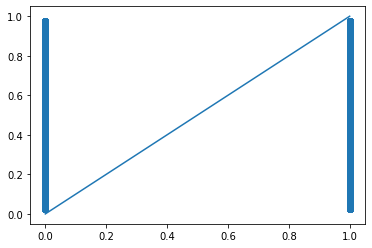

In [20]:
plt.plot(train[target], train[target])
plt.scatter(train[target], lgb_oof)

# Features importances

Text(0.5, 1.0, 'LGB feature importances')

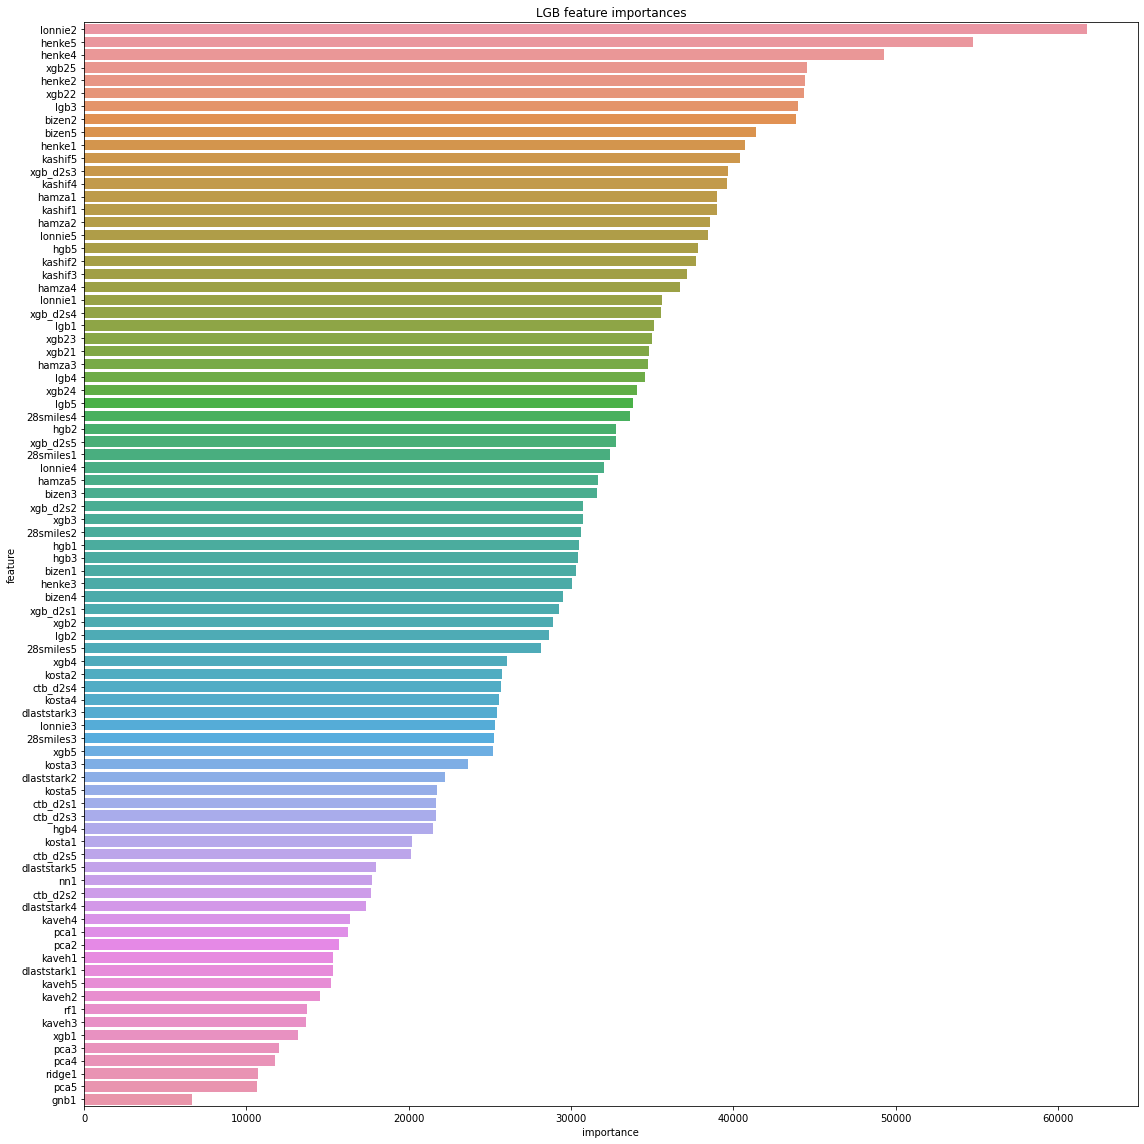

In [21]:
order = list(lgb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=lgb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("LGB feature importances")

# Submission

In [22]:
submission[target] = lgb_pred
submission.to_csv("submission.csv", index=False)

submission

,id,target
0,1000000,0.681552
1,1000001,0.282960
2,1000002,0.912142
3,1000003,0.799751
4,1000004,0.310930
...,...,...
499995,1499995,0.971937
499996,1499996,0.789654
499997,1499997,0.327922
499998,1499998,0.500785


# Log

///// lv0+lv1 raw /////
ver1
